<a href="https://colab.research.google.com/github/Rucamont/ForeCastRetail/blob/main/ForeCastRetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
!pip install catboost shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shap
shap.initjs()

In [83]:
data = pd.read_csv("ventas.csv", encoding="utf-8", delimiter=';', dtype={'EAN':str},decimal=',')
data.shape

(544916, 12)

In [84]:
data.head()

,Año,Semestre,Sucursal,Fecha,GrupoSCPM,EAN,CodSap,Producto,UM,Tipo,VentaNeta,Cantidad
0,2017,SEMESTRE 1,LA LIBERTAD,2017-01-01 00:00:00.000,Grupo 7 - Cebolla paiteña (fresco),940,NaN,CEBOLLA COLORADA,Kilogramo,Venta,2.44,2.220
1,2017,SEMESTRE 1,CALIFORNIA,2017-01-02 00:00:00.000,Grupo 1 - Arroz blanco,7861095000084,NaN,ARROZ DE LA OLLA 2 KG,Unidades,Venta,3.00,1.000
2,2017,SEMESTRE 1,CALIFORNIA,2017-01-02 00:00:00.000,Grupo 14 - Atún enlatado,722008312311,NaN,ATUN VAN CAMPS DORADA 160 GR,Unidades,Venta,8.10,5.000
3,2017,SEMESTRE 1,CALIFORNIA,2017-01-02 00:00:00.000,Grupo 9 - Pollo crudo,505,NaN,POLLO COMPLETO,Kilogramo,Venta,13.00,4.236
4,2017,SEMESTRE 1,CEIBOS,2017-01-02 00:00:00.000,Grupo 14 - Atún enlatado,722008000133,NaN,ATUN TRIPACK ACEITE ETIQ AZUL,Unidades,Venta,2.69,1.000


Porcentaje faltante

In [85]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

Año            0.0
Semestre       0.0
Sucursal       0.0
Fecha          0.0
GrupoSCPM      0.0
EAN            0.0
CodSap       100.0
Producto       0.0
UM             0.0
Tipo           0.0
VentaNeta      0.0
Cantidad       0.0
dtype: float64

In [86]:
data[data.CodSap.isnull()].head()


,Año,Semestre,Sucursal,Fecha,GrupoSCPM,EAN,CodSap,Producto,UM,Tipo,VentaNeta,Cantidad
0,2017,SEMESTRE 1,LA LIBERTAD,2017-01-01 00:00:00.000,Grupo 7 - Cebolla paiteña (fresco),940,NaN,CEBOLLA COLORADA,Kilogramo,Venta,2.44,2.220
1,2017,SEMESTRE 1,CALIFORNIA,2017-01-02 00:00:00.000,Grupo 1 - Arroz blanco,7861095000084,NaN,ARROZ DE LA OLLA 2 KG,Unidades,Venta,3.00,1.000
2,2017,SEMESTRE 1,CALIFORNIA,2017-01-02 00:00:00.000,Grupo 14 - Atún enlatado,722008312311,NaN,ATUN VAN CAMPS DORADA 160 GR,Unidades,Venta,8.10,5.000
3,2017,SEMESTRE 1,CALIFORNIA,2017-01-02 00:00:00.000,Grupo 9 - Pollo crudo,505,NaN,POLLO COMPLETO,Kilogramo,Venta,13.00,4.236
4,2017,SEMESTRE 1,CEIBOS,2017-01-02 00:00:00.000,Grupo 14 - Atún enlatado,722008000133,NaN,ATUN TRIPACK ACEITE ETIQ AZUL,Unidades,Venta,2.69,1.000


Eliminar columna codSap

In [87]:
data.drop(columns='CodSap', inplace=True)
data= data[data['Tipo']=='Venta']

In [88]:
data.head()

,Año,Semestre,Sucursal,Fecha,GrupoSCPM,EAN,Producto,UM,Tipo,VentaNeta,Cantidad
0,2017,SEMESTRE 1,LA LIBERTAD,2017-01-01 00:00:00.000,Grupo 7 - Cebolla paiteña (fresco),940,CEBOLLA COLORADA,Kilogramo,Venta,2.44,2.220
1,2017,SEMESTRE 1,CALIFORNIA,2017-01-02 00:00:00.000,Grupo 1 - Arroz blanco,7861095000084,ARROZ DE LA OLLA 2 KG,Unidades,Venta,3.00,1.000
2,2017,SEMESTRE 1,CALIFORNIA,2017-01-02 00:00:00.000,Grupo 14 - Atún enlatado,722008312311,ATUN VAN CAMPS DORADA 160 GR,Unidades,Venta,8.10,5.000
3,2017,SEMESTRE 1,CALIFORNIA,2017-01-02 00:00:00.000,Grupo 9 - Pollo crudo,505,POLLO COMPLETO,Kilogramo,Venta,13.00,4.236
4,2017,SEMESTRE 1,CEIBOS,2017-01-02 00:00:00.000,Grupo 14 - Atún enlatado,722008000133,ATUN TRIPACK ACEITE ETIQ AZUL,Unidades,Venta,2.69,1.000


In [89]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

Año          0.0
Semestre     0.0
Sucursal     0.0
Fecha        0.0
GrupoSCPM    0.0
EAN          0.0
Producto     0.0
UM           0.0
Tipo         0.0
VentaNeta    0.0
Cantidad     0.0
dtype: float64

In [90]:
data[data['EAN']=='']

,Año,Semestre,Sucursal,Fecha,GrupoSCPM,EAN,Producto,UM,Tipo,VentaNeta,Cantidad


In [91]:
data["Fecha"] = pd.to_datetime(data.Fecha, cache=True)

data.Fecha.max() - data.Fecha.min()

Timedelta('1491 days 00:00:00')

Rango de fechas

In [92]:

print("Datafile starts with timepoint {}".format(data.Fecha.min()))
print("Datafile ends with timepoint {}".format(data.Fecha.max()))

Datafile starts with timepoint 2017-01-01 00:00:00
Datafile ends with timepoint 2021-01-31 00:00:00


Codigos unicos de EAN

In [93]:
data.EAN.nunique()

325

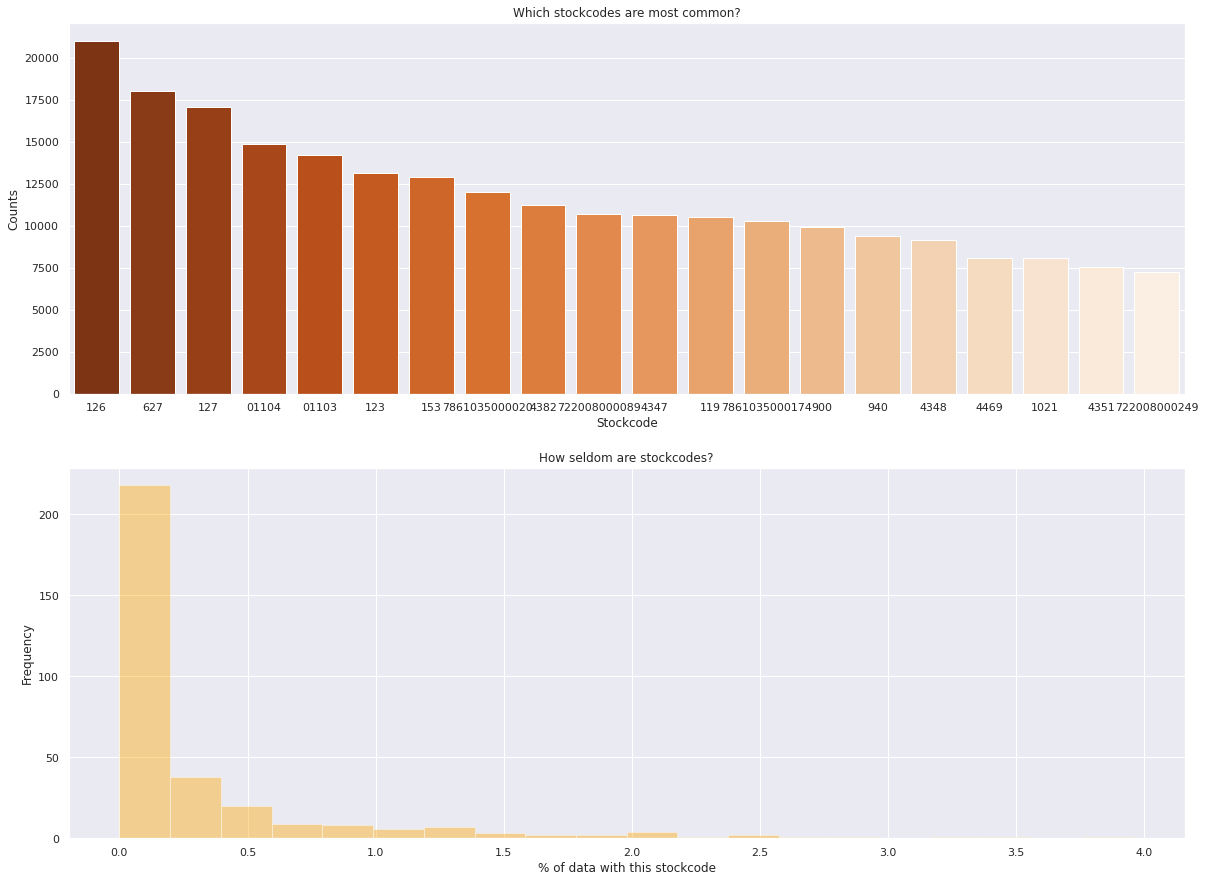

In [94]:
stockcode_counts = data.EAN.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

In [95]:
data.Producto.nunique()

320

In [96]:
data[data['Producto']=='Nan']

,Año,Semestre,Sucursal,Fecha,GrupoSCPM,EAN,Producto,UM,Tipo,VentaNeta,Cantidad


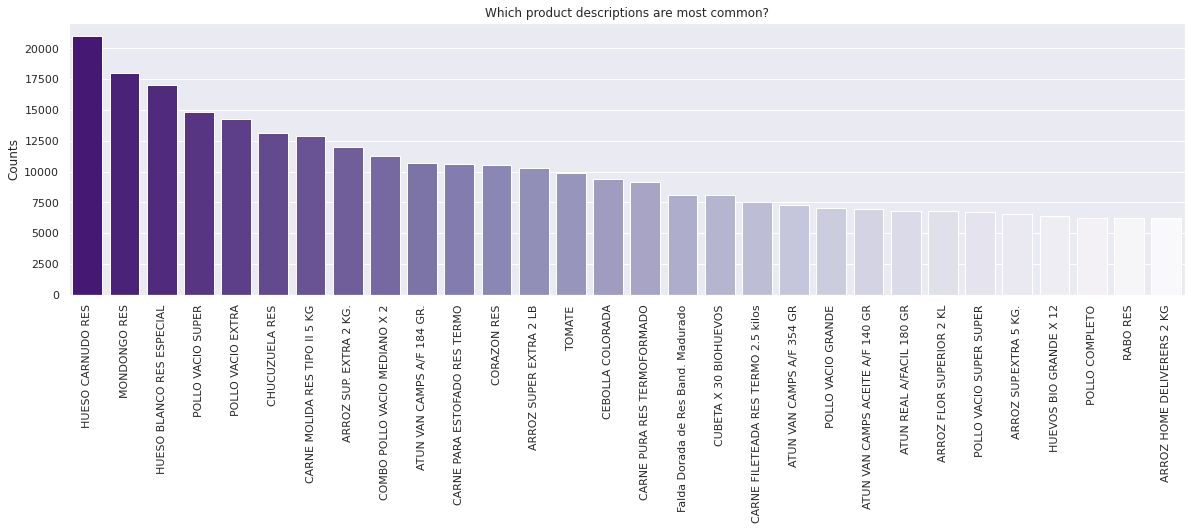

In [97]:
description_counts = data.Producto.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

**Codigos con la misma descripcion**

In [98]:
data.groupby("Producto").EAN.nunique().sort_values(ascending=False).iloc[0:10]


Producto
CEBOLLA COLORADA EN BANDEJA                          3
LOMO DE ATUN EN ACEITE DE OLIVA 80 GR                2
ARROZ FLOR SUPERIOR 5 KG                             2
POLLO VACIO SUPER SUPER                              2
ARROZ CHEF 1 LB                                      1
HUEVOS POR UNIDAD                                    1
LOMO DE ATUN EN ACEITE GIRASOL 142 GR                1
LOMO DE ATUN AHUMADO EN ACEITE VEGETAL A/F 160 GR    1
LOMITOS EN AGUA REAL 140 GR                          1
LOMITOS ACEITE GIRASOL TRIPACK 80 GR                 1
Name: EAN, dtype: int64

In [99]:
data[data['Producto']=='ARROZ FLOR SUPERIOR 5 KG'].EAN.unique()


array(['7861067600069', '7861066760009'], dtype=object)

In [100]:
data.loc[data['Producto']=='CEBOLLA COLORADA EN BANDEJA','EAN'] = '4053'
data.loc[data['Producto']=='LOMO DE ATUN EN ACEITE DE OLIVA 80 GR','EAN'] = '7861167301668'
data.loc[data['Producto']=='POLLO VACIO SUPER SUPER','EAN'] = '4384'
data.loc[data['Producto']=='ARROZ FLOR SUPERIOR 5 KG','EAN'] = '7861067600069'

data.groupby("Producto").EAN.nunique().sort_values(ascending=False).iloc[0:10]



Producto
ARROZ CHEF 1 LB                                      1
ARROZ DE LA OLLA 2 KG                                1
LOMO DE ATUN EN ACEITE GIRASOL 354 GR                1
LOMO DE ATUN EN ACEITE GIRASOL 180 GR                1
LOMO DE ATUN EN ACEITE GIRASOL 142 GR                1
LOMO DE ATUN EN ACEITE DE OLIVA 80 GR                1
LOMO DE ATUN AHUMADO EN ACEITE VEGETAL A/F 160 GR    1
LOMITOS EN AGUA REAL 140 GR                          1
LOMITOS ACEITE GIRASOL TRIPACK 80 GR                 1
LIBRILLO DE RES                                      1
Name: EAN, dtype: int64

**Sucursales**

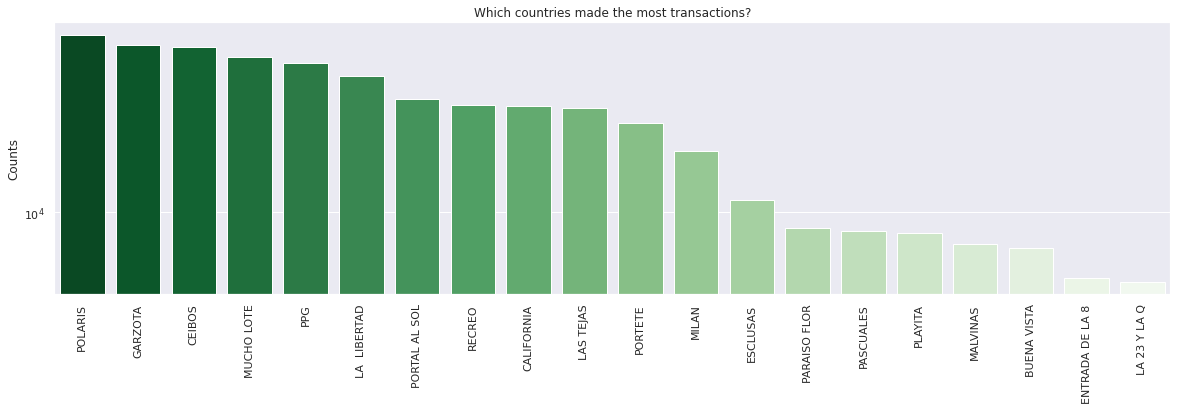

In [101]:
country_counts = data.Sucursal.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

In [102]:
data.VentaNeta.describe()

count    530763.000000
mean         48.828868
std         193.231368
min        -484.965500
25%           2.820000
50%           7.020000
75%          21.450000
max       13117.888000
Name: VentaNeta, dtype: float64

In [103]:
data=data[data['VentaNeta']>0]

In [104]:
data.VentaNeta.describe()

count    5.054100e+05
mean     5.128152e+01
std      1.976983e+02
min      2.220000e-16
25%      3.120000e+00
50%      7.522200e+00
75%      2.314195e+01
max      1.311789e+04
Name: VentaNeta, dtype: float64

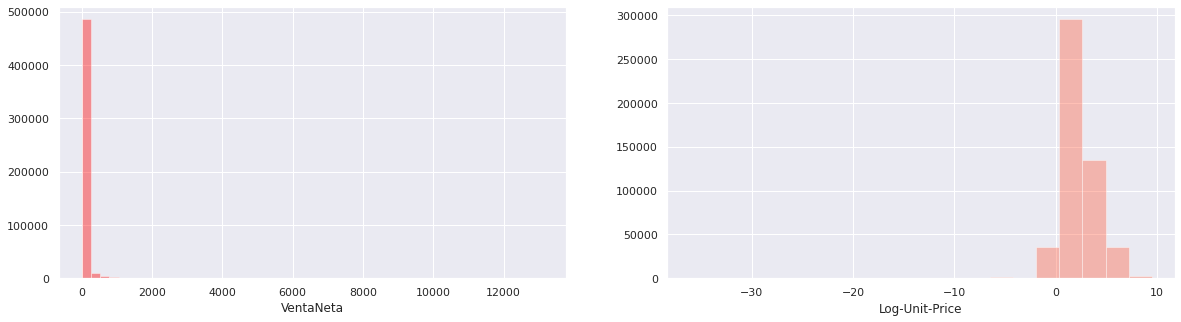

In [105]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.VentaNeta, ax=ax[0], kde=False, color="red")
sns.distplot(np.log(data.VentaNeta), ax=ax[1], bins=20, color="tomato", kde=False)
ax[1].set_xlabel("Log-Unit-Price");

In [106]:
np.exp(-1)

0.36787944117144233

In [107]:
np.exp(10)

22026.465794806718

In [108]:
np.quantile(data.VentaNeta, 0.95)


209.4591045

In [109]:
data = data.loc[(data.VentaNeta > 0.36) & (data.VentaNeta < 22026)].copy()
data

,Año,Semestre,Sucursal,Fecha,GrupoSCPM,EAN,Producto,UM,Tipo,VentaNeta,Cantidad
0,2017,SEMESTRE 1,LA LIBERTAD,2017-01-01,Grupo 7 - Cebolla paiteña (fresco),940,CEBOLLA COLORADA,Kilogramo,Venta,2.440000,2.220
1,2017,SEMESTRE 1,CALIFORNIA,2017-01-02,Grupo 1 - Arroz blanco,7861095000084,ARROZ DE LA OLLA 2 KG,Unidades,Venta,3.000000,1.000
2,2017,SEMESTRE 1,CALIFORNIA,2017-01-02,Grupo 14 - Atún enlatado,722008312311,ATUN VAN CAMPS DORADA 160 GR,Unidades,Venta,8.100000,5.000
3,2017,SEMESTRE 1,CALIFORNIA,2017-01-02,Grupo 9 - Pollo crudo,505,POLLO COMPLETO,Kilogramo,Venta,13.000000,4.236
4,2017,SEMESTRE 1,CEIBOS,2017-01-02,Grupo 14 - Atún enlatado,722008000133,ATUN TRIPACK ACEITE ETIQ AZUL,Unidades,Venta,2.690000,1.000
...,...,...,...,...,...,...,...,...,...,...,...
530758,2021,SEMESTRE 1,PPG,2021-01-31,Grupo 10 - Carne de res cruda,4348,CARNE PURA RES TERMOFORMADO,Kilogramo,Venta,38.325425,6.060
530759,2021,SEMESTRE 1,PPG,2021-01-31,Grupo 14 - Atún enlatado,7862100604112,ATUN REAL A/F ACEITE GIRASOL 140 GR,Unidades,Venta,8.880000,6.000
530760,2021,SEMESTRE 1,PPG,2021-01-31,Grupo 2 - Harina de trigo,7861025522303,HARINA YA C/ POLVO DE HORNEAR 500 GR,Unidades,Venta,2.640000,2.000
530761,2021,SEMESTRE 1,PPG,2021-01-31,Grupo 2 - Harina de trigo,7862117321514,HARINA AMANCAY S-POLVO HORNEAR FDA 250 GR,Unidades,Venta,0.480000,1.000


In [110]:
data.Cantidad.describe()

count    503267.000000
mean         20.484471
std          91.580738
min           0.060000
25%           1.000000
50%           2.290000
75%           6.905000
max        7000.000000
Name: Cantidad, dtype: float64

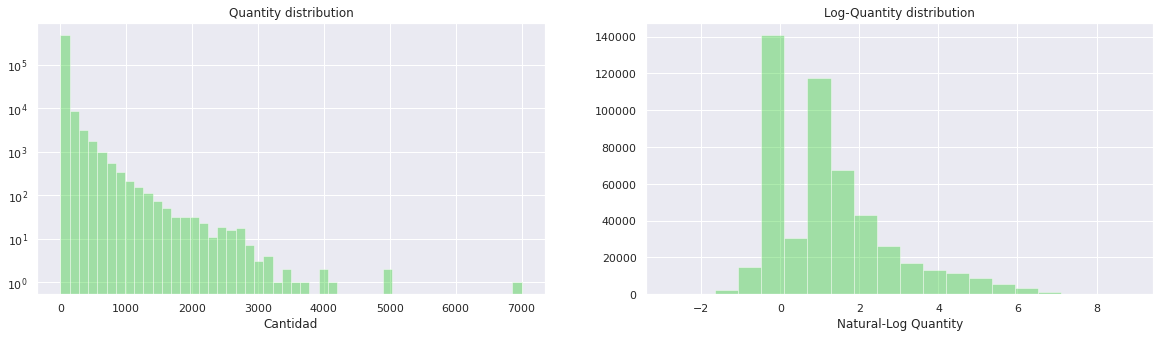

In [111]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.Cantidad, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(data.Cantidad), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");

In [112]:
np.exp(6)

403.4287934927351

In [119]:
np.quantile(data.Cantidad, 0.95)


87.61069999999995

In [114]:
data.Cantidad.max()

7000.0

In [120]:
data = data.loc[data.Cantidad < 100].copy()
data.shape

(480568, 11)

In [121]:

data["Year"] = data.Fecha.dt.year
data["Quarter"] = data.Fecha.dt.quarter
data["Month"] = data.Fecha.dt.month
data["Week"] = data.Fecha.dt.week
data["Weekday"] = data.Fecha.dt.weekday
data["Day"] = data.Fecha.dt.day
data["Dayofyear"] = data.Fecha.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

In [122]:
data.head()

,Año,Semestre,Sucursal,Fecha,GrupoSCPM,EAN,Producto,UM,Tipo,VentaNeta,Cantidad,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
0,2017,SEMESTRE 1,LA LIBERTAD,2017-01-01,Grupo 7 - Cebolla paiteña (fresco),940,CEBOLLA COLORADA,Kilogramo,Venta,2.44,2.220,2017,1,1,52,6,1,1,2017-01-01
1,2017,SEMESTRE 1,CALIFORNIA,2017-01-02,Grupo 1 - Arroz blanco,7861095000084,ARROZ DE LA OLLA 2 KG,Unidades,Venta,3.00,1.000,2017,1,1,1,0,2,2,2017-01-02
2,2017,SEMESTRE 1,CALIFORNIA,2017-01-02,Grupo 14 - Atún enlatado,722008312311,ATUN VAN CAMPS DORADA 160 GR,Unidades,Venta,8.10,5.000,2017,1,1,1,0,2,2,2017-01-02
3,2017,SEMESTRE 1,CALIFORNIA,2017-01-02,Grupo 9 - Pollo crudo,505,POLLO COMPLETO,Kilogramo,Venta,13.00,4.236,2017,1,1,1,0,2,2,2017-01-02
4,2017,SEMESTRE 1,CEIBOS,2017-01-02,Grupo 14 - Atún enlatado,722008000133,ATUN TRIPACK ACEITE ETIQ AZUL,Unidades,Venta,2.69,1.000,2017,1,1,1,0,2,2,2017-01-02
